In [1]:
import torch
import numpy as np 
from matplotlib import pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import pickle
from functools import reduce
%matplotlib inline

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                         shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

In [5]:
print(len(trainloader))
print(len(testloader))

938
157


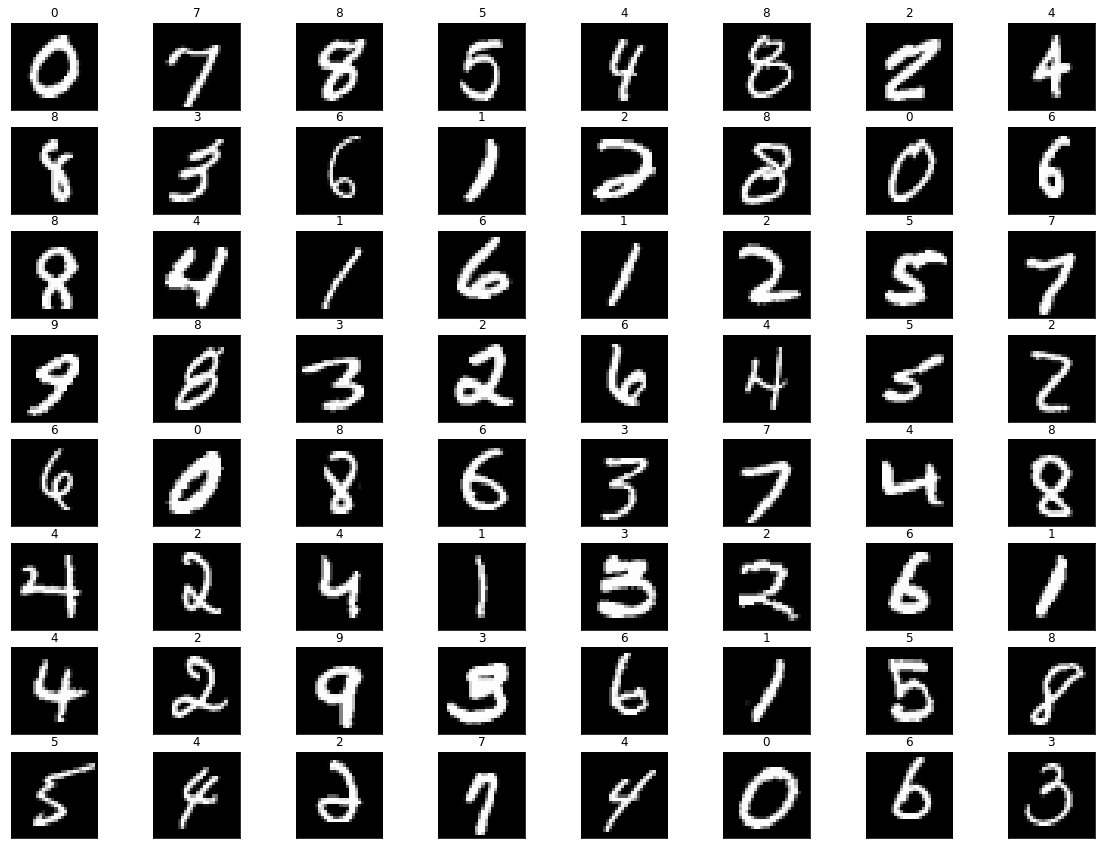

In [6]:
def imshow(ax, img, label):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    ax.imshow(npimg[0], cmap='gray')
    ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    right='off',
    left='off',
    labelbottom='off',
    labelleft='off') # labels along the bottom edge are off
    ax.set_title(label)

plt.rcParams['figure.figsize'] = (20, 15)
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
plot_sz = int(np.sqrt(len(images)))
fig, axes = plt.subplots(plot_sz, plot_sz)
for i, image in enumerate(images):
    imshow(axes[int(i/plot_sz), i%plot_sz], image, labels[i])

In [7]:
class Net(nn.Module):
    def __init__(self, dropout=False):
        super(Net, self).__init__()
        self.criterion = nn.CrossEntropyLoss()
        self.dropout = dropout
        self.fc1 = nn.Linear(28*28, 800)
        self.fc2 = nn.Linear(800, 800)
        self.fc3 = nn.Linear(800, 10)
        self.drop = nn.Dropout(p=0.5)

    def forward(self, x, eval_dropout=False, mask=None):
        #print(x.shape)
        x = x.view(-1, 28 * 28)
        #print(x.shape)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        #print(x)
        if self.dropout and not eval_dropout:
            x = self.drop(x) * (1-0.5) 
        if eval_dropout:
            x *= 0.5
        if mask is not None:
            x *= mask
        #print(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x
    
    def predict_proba(self, x, eval_dropout=False, mask=None):
        return nn.Softmax(dim=1)(self.forward(x, eval_dropout=eval_dropout, mask=mask))
    
    def predict(self, x, evaluating_with_dropout=False, mode=None, N=0):
        if not evaluating_with_dropout:
            return torch.max(self.predict_proba(x), 1)[1]
        if evaluating_with_dropout:
            if mode == 1:
                # multiply the hidden layer by 0.5
                return torch.max(self.predict_proba(x, eval_dropout=True), 1)[1]
            if mode == 2:
                #sample N dropout masks and average the pre-softmax value
                pre_softs = []
                for i in range(N):
                    mask = Variable(torch.from_numpy(np.random.randint(0, 2, 800).astype(float)).float())
                    if torch.cuda.is_available:
                        mask = mask.cuda()
                    pre_soft = self.forward(x, eval_dropout=False, mask=mask)
                    pre_softs.append(pre_soft)
                #print(pre_softs)
                avg_pre_soft = reduce(lambda x, y: x+y, pre_softs)/N
                #print(avg_pre_soft)
                return torch.max(nn.Softmax(dim=1)(avg_pre_soft), 1)[1]        
            if mode == 3:
                #sample N dropout masks and average the N predictions
                probas = []
                for i in range(N):
                    mask = Variable(torch.from_numpy(np.random.randint(0, 2, 800).astype(float)).float())
                    if torch.cuda.is_available:
                        mask = mask.cuda()
                    proba = self.predict_proba(x, eval_dropout=False, mask=mask)
                    probas.append(proba)
                avg_probas = reduce(lambda x, y: x+y, probas)/N
                return torch.max(avg_probas, 1)[1]
            
    
    def loss(self, x, target):
        pre_softmax = self(x)
        return self.criterion(pre_softmax, target)
    
    def param_norms(self):
        norm_sq = 0
        for param in list(self.parameters()):
            if param.ndimension()==2:
                norm_sq += param.norm(2)**2
        return torch.sqrt(norm_sq)

net = Net()

In [8]:
def init_glorot(m):
    gain = nn.init.calculate_gain('relu')
    if type(m) == nn.Linear:
        nn.init.xavier_uniform(m.weight,gain=gain)
        nn.init.constant(m.bias,0)

In [9]:
def error_accuracy(mlp, loader, evaluating_with_dropout=False, mode=None, N=0, dl='mlp'):
    loss = 0
    correct = 0
    for idx, (data, target) in enumerate(loader):
        if torch.cuda.is_available:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = mlp(data)
        loss += F.cross_entropy(output, target, size_average=False).data[0] # sum up batch loss
        if dl=='mlp':
            pred = mlp.predict(data, evaluating_with_dropout=evaluating_with_dropout, mode=mode, N=N)
        else:
            pred = mlp.predict(data)
        correct += pred.data.eq(target.data.view_as(pred)).cpu().sum()

    loss /= len(loader.sampler)
    accuracy = correct / len(loader.sampler)
    error = 1 - accuracy
    
    return loss, error

In [10]:
def train(n_epochs=100, lr=0.02, l2reg=2.5,
          dropout=False, dl='mlp', BN=False,
          print_every=200, print_every_meta=10):
    if dl=='mlp':
        net = Net(dropout=dropout)
        net.apply(init_glorot)
    else:
        print('Using a CNN')
        net = CNN(dropout=dropout, BN=BN)
    if torch.cuda.is_available:
        print('Using CUDA')
        net = net.cuda()
    optimizer = optim.SGD(net.parameters(), lr=lr) if dl == 'mlp' else optim.Adam(net.parameters(), lr = lr)
    train_losses, train_errors, test_losses, test_errors = [], [], [], []
    norms = []
    if dl == 'cnn':
        train_loss, train_error = error_accuracy(net, trainloader, dl=dl)
        test_loss, test_error = error_accuracy(net, testloader, dl=dl)
    if dl == 'mlp':
        train_loss, train_error = error_accuracy(net, trainloader, dl=dl, evaluating_with_dropout=dropout, mode=1)
        test_loss, test_error = error_accuracy(net, testloader, dl=dl, evaluating_with_dropout=dropout, mode=1)
        norm = net.param_norms()
        norms.append(norm.data[0])
        print('Norm of param: {:.2f}'.format(norm.data[0]))
    print("Epoch {}: (train_error: {:.2e}, valid_error: {:.2e})".format(0, train_error, test_error))        
    train_losses.append(train_loss)
    train_errors.append(train_error)
    test_losses.append(test_loss)
    test_errors.append(test_error)
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            if torch.cuda.is_available:
                inputs = inputs.cuda()
                labels = labels.cuda()
            inputs, labels = Variable(inputs), Variable(labels)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss1 = net.loss(inputs, labels)
            loss2 = .5 * l2reg/len(trainloader.sampler) * net.param_norms()**2 if dl == 'mlp' else 0
            loss = loss1 + loss2
            loss.backward()
            optimizer.step()
            if dl == 'mlp':
                norm = net.param_norms()
                norms.append(norm.data[0])
            running_loss += loss.data[0]
            if (i + 1) % print_every == 0:    
                print('[%d, %5d] loss: %.2e' % (epoch + 1, i + 1, running_loss / print_every))
                running_loss = 0.0
        if dl == 'cnn':
            train_loss, train_error = error_accuracy(net, trainloader, dl=dl)
            test_loss, test_error = error_accuracy(net, testloader, dl=dl)
        if dl == 'mlp':
            train_loss, train_error = error_accuracy(net, trainloader, dl=dl, evaluating_with_dropout=dropout, mode=1)
            test_loss, test_error = error_accuracy(net, testloader, dl=dl, evaluating_with_dropout=dropout, mode=1)

        if (epoch + 1) % print_every_meta == 0:
            if dl == 'mlp':
                print('Norm of param: {:.3f}'.format(norm.data[0]))
            #print("Epoch {}: (train_loss: {:.2e}, valid_loss: {:.2e})".format(epoch + 1, train_loss, valid_loss))
            print("Epoch {}: (train_error: {:.2e}, valid_error: {:.2e})".format(epoch + 1, train_error, test_error))
        train_losses.append(train_loss)
        train_errors.append(train_error)
        test_losses.append(test_loss)
        test_errors.append(test_error)
        

    return ({'train_losses': train_losses,
            'train_errors': train_errors,
            'test_losses': test_losses,
            'test_errors': test_errors,
            'norms': norms}, net)

## Early stopping and weight decay

In [ ]:
out_data_0, net_0 = train(print_every=10000, lr=0.02, l2reg=0, print_every_meta=5)
pickle.dump(out_data_0, open('data_lr_0.02_l2reg_0.pkl', 'wb'))

In [ ]:
out_data, net = train(print_every=10000, lr=0.02, l2reg=2.5, print_every_meta=5)
pickle.dump(out_data, open('data_lr_0.02_l2reg_2.5.pkl', 'wb'))

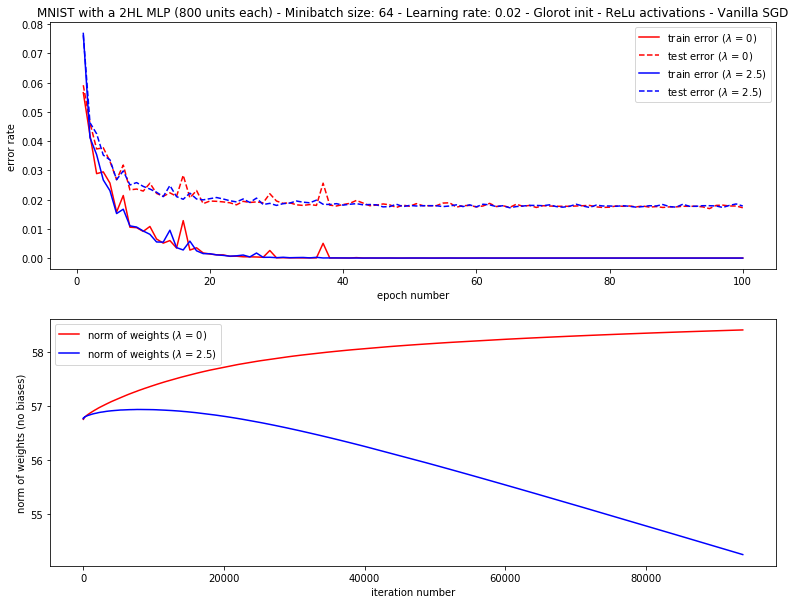

In [486]:
out_data0 = pickle.load(open('data_lr_0.02_l2reg_0.pkl', 'rb'))
out_data = pickle.load(open('data_lr_0.02_l2reg_2.5.pkl', 'rb'))
plt.rcParams['figure.figsize'] = (13, 10)
fig, axes=plt.subplots(2, 1)
axes[0].set_title("MNIST with a 2HL MLP (800 units each) - Minibatch size: 64 - Learning rate: 0.02 - Glorot init - ReLu activations - Vanilla SGD")
axes[0].plot(range(1, 101), out_data0['train_errors'][1:], 'r-', label='train error ($\lambda$ = 0)')
axes[0].plot(range(1, 101), out_data0['test_errors'][1:], 'r--', label='test error ($\lambda$ = 0)')
axes[0].plot(range(1, 101), out_data['train_errors'][1:], 'b-', label='train error ($\lambda$ = 2.5)')
axes[0].plot(range(1, 101), out_data['test_errors'][1:], 'b--', label='test error ($\lambda$ = 2.5)')
axes[0].set_xlabel("epoch number")
axes[0].set_ylabel("error rate")
axes[0].legend()
axes[1].plot(out_data0['norms'], 'r', label='norm of weights ($\lambda$ = 0)')
axes[1].plot(out_data['norms'], 'b', label='norm of weights ($\lambda$ = 2.5)')
axes[1].set_xlabel("iteration number")
axes[1].set_ylabel("norm of weights (no biases)")
axes[1].legend()
plt.savefig('weightdecay.png')
plt.show()

## Dropout

In [11]:
out_data_drop, net_drop = train(print_every=10000, lr=0.02, l2reg=0, dropout=True, print_every_meta=5)

Using CUDA
Norm of param: 56.77
Epoch 0: (train_error: 9.03e-01, valid_error: 9.03e-01)
Norm of param: 57.216
Epoch 5: (train_error: 3.66e-02, valid_error: 3.96e-02)
Norm of param: 57.483
Epoch 10: (train_error: 2.34e-02, valid_error: 2.79e-02)
Norm of param: 57.702
Epoch 15: (train_error: 1.67e-02, valid_error: 2.60e-02)
Norm of param: 57.896
Epoch 20: (train_error: 1.17e-02, valid_error: 2.31e-02)
Norm of param: 58.070
Epoch 25: (train_error: 9.08e-03, valid_error: 2.05e-02)
Norm of param: 58.228
Epoch 30: (train_error: 6.62e-03, valid_error: 2.00e-02)
Norm of param: 58.375
Epoch 35: (train_error: 5.25e-03, valid_error: 1.90e-02)
Norm of param: 58.510
Epoch 40: (train_error: 3.62e-03, valid_error: 1.89e-02)
Norm of param: 58.636
Epoch 45: (train_error: 2.22e-03, valid_error: 1.75e-02)
Norm of param: 58.753
Epoch 50: (train_error: 2.37e-03, valid_error: 1.85e-02)
Norm of param: 58.863
Epoch 55: (train_error: 1.27e-03, valid_error: 1.71e-02)
Norm of param: 58.965
Epoch 60: (train_error

In [12]:
error_mode_1 = error_accuracy(net_drop, testloader, evaluating_with_dropout=True, mode=1)[1]
print(error_mode_1)

0.016599999999999948


In [13]:
N_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1000]

In [14]:
error_mode2_N = [error_accuracy(net_drop, testloader, evaluating_with_dropout=True, mode=2, N=N)[1] for N in N_values]

In [15]:
error_mode3_N = [error_accuracy(net_drop, testloader, evaluating_with_dropout=True, mode=3, N=N)[1] for N in N_values]

ValueError: x and y must have same first dimension, but have shapes (11,) and (10,)

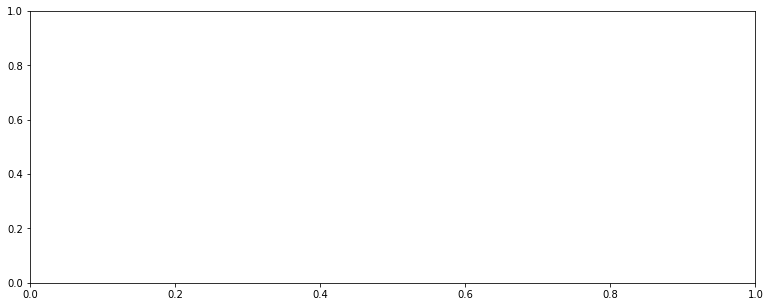

In [16]:
plt.rcParams['figure.figsize'] = (13, 5)
plt.plot(N_values, 10 * [error_mode_1], label='multiplication')
plt.plot(N_values, error_mode2_N, '-o', label='pre-softmax mask avg')
plt.plot(N_values, error_mode3_N, '-o', label='post-softmax mask avg')
plt.legend()
plt.xlabel('Number of masks averaged on')
plt.ylabel('Test error')
plt.title('Comparison of MNIST test errors with 3 different evaluation methods when using dropout')
plt.savefig('dropout_bis.png')
plt.show()

In [400]:
class CNN(nn.Module):
    """Convnet Classifier"""
    def __init__(self, dropout=False, BN=False):
        super(CNN, self).__init__()
        self.dropout = dropout
        self.BN = BN
        self.criterion = nn.CrossEntropyLoss()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        self.clf = nn.Linear(128, 10)

    def forward(self, x):
        BN = self.BN
        dropout = self.dropout
        x = self.conv1(x)
        if dropout:
            x = nn.Dropout(p=0.5)(x)
        if BN:
            x = self.bn1(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(kernel_size=(2,2), stride=2)(x)
        x = self.conv2(x)
        if dropout:
            x = nn.Dropout(p=0.5)(x)
        if BN:
            x = self.bn2(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(kernel_size=(2,2), stride=2)(x)
        x = self.conv3(x)
        if dropout:
            x = nn.Dropout(p=0.5)(x)
        if BN:
            x = self.bn3(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(kernel_size=(2,2), stride=2)(x)
        x = self.conv4(x)
        if dropout:
            x = nn.Dropout(p=0.5)(x)
        if BN:
            x = self.bn4(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(kernel_size=(2,2), stride=2)(x)
        return self.clf(x.squeeze())
    
    def predict_proba(self, x):
        return nn.Softmax(dim=1)(self.forward(x))
    
    def predict(self, x):
        return torch.max(self.predict_proba(x), 1)[1]
        
    def loss(self, x, target):
        pre_softmax = self.forward(x)
        return self.criterion(pre_softmax, target)
    
    def param_norms(self):
        return torch.from_numpy(np.array([0]))
    
cnn = CNN()
print(cnn)

CNN(
  (criterion): CrossEntropyLoss(
  )
  (conv1): Conv2d (1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d (16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d (32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (clf): Linear(in_features=128, out_features=10)
)


In [ ]:
out_data, cnn = train(dl='cnn', print_every_meta=1, n_epochs=10, lr=1e-4)
pickle.dump(out_data, open('data_cnn_nodrop_nobnpkl', 'wb'))

In [349]:
out_data_bn, cnn_bn = train(dl='cnn', print_every_meta=1, n_epochs=10, lr=1e-4, BN=True)
pickle.dump(out_data, open('data_cnn_nodrop_bn.pkl', 'wb'))

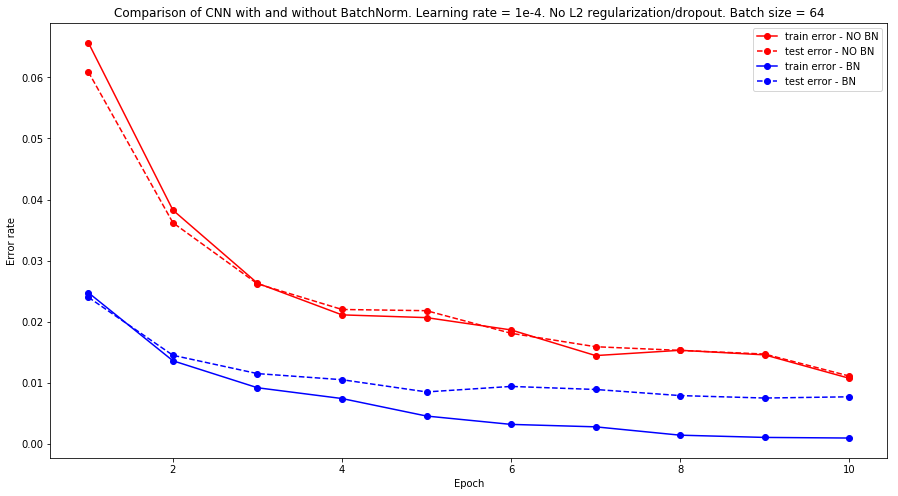

In [484]:
out_data = pickle.load(open('data_cnn_nodrop_nobnpkl', 'rb'))
out_data_bn = pickle.load(open('data_cnn_nodrop_bn.pkl', 'rb'))
plt.rcParams['figure.figsize'] = (15, 8)
fig, axes=plt.subplots(1, 1)
axes.plot(range(1, 11), out_data['train_errors'][1:], 'ro-', label='train error - NO BN')
axes.plot(range(1, 11), out_data['test_errors'][1:], 'ro--', label='test error - NO BN')
axes.legend()
axes.plot(range(1, 11), out_data_bn['train_errors'][1:], 'bo-', label='train error - BN')
axes.plot(range(1, 11), out_data_bn['test_errors'][1:], 'bo--', label='test error - BN')
axes.legend()
axes.set_xlabel('Epoch')
axes.set_ylabel('Error rate')
plt.title('Comparison of CNN with and without BatchNorm. Learning rate = 1e-4. No L2 regularization/dropout. Batch size = 64')
plt.savefig('Batchnorm.png')
plt.show()